In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from astropy.coordinates import get_sun, SkyCoord, EarthLocation, AltAz, get_moon
from astropy.time import Time
from lsst.sims.utils import Site, raDec2Hpid, m5_flat_sed
from astropy import units as u
from lsst.sims.skybrightness_pre import SkyModelPre
import healpy as hp
from lsst.sims.seeingModel import SeeingModel
from lsst.sims.downtimeModel import ScheduledDowntimeData

In [2]:
site = Site('LSST')
location = EarthLocation(lat=site.latitude, lon=site.longitude,height=site.height)

In [3]:
nyears = 2.2
mjd = np.arange(59853.5, 59853.5+365.25*nyears, 20./60/24.)
times = Time(mjd, format='mjd', location=location)

airmass_limit = 2.5 # demand airmass lower than this
twilight_limit = -18.  # Sun below this altitude in degrees
dist_to_moon_limit = 30.  # minimum distance to keep from moon degrees

In [4]:
sun_coords = get_sun(times)
moon_coords = get_moon(times)

In [5]:
sched_downtime_data = ScheduledDowntimeData(Time(mjd[0], format='mjd'))
observatory_up = np.ones(mjd.size, dtype=bool)
for dt in sched_downtime_data():
    indx = np.where((mjd >= dt['start'].mjd) & (mjd <= dt['end'].mjd))[0]
    observatory_up[indx] = False


In [6]:
lst = times.sidereal_time('mean')

In [7]:
sun_altaz = sun_coords.transform_to(AltAz(location=location))

# generate a night label for each timestep
sun_rise = np.where((sun_altaz.alt[0:-1] < 0) & (sun_altaz.alt[1:] > 0))[0]
night = np.zeros(mjd.size, dtype=int)
night[sun_rise] = 1
night = np.cumsum(night) + 1 #  1-index for night

In [8]:
sun_down = np.where(sun_altaz.alt < twilight_limit*u.deg)[0]

In [9]:
# ELAIS S1
ddf_coord = SkyCoord(ra=9.45*u.deg, dec=-44.*u.deg)

In [10]:
ddf_altaz = ddf_coord.transform_to(AltAz(location=location, obstime=times))
ddf_airmass = 1./np.cos(np.radians(90.-ddf_altaz.az.deg))

In [11]:
# HA = LST - RA
ha = lst - ddf_coord.ra

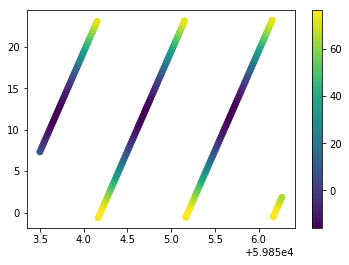

In [12]:
plt.scatter(mjd[0:200], ha[0:200], c=ddf_altaz.alt[0:200])
plt.colorbar()

In [13]:
# need the moon, to avoid getting too close
# Maybe airmass. and skybrightness. Probably only need 1-filter for skybrightness?
# Should load up scheduled downtimes

In [14]:
nside = 32
ddf_indx = raDec2Hpid(nside,ddf_coord.ra.deg, ddf_coord.dec.deg)
sm = SkyModelPre()

In [15]:
g_sb = mjd*0+np.nan

indices = np.where((sun_altaz.alt < twilight_limit*u.deg) & (ddf_airmass > airmass_limit))[0]
# In theory, one could reach into the sky brightness model and do a much faster interpolation
# There might be an airmass limit on the sky brightness.
for indx in sun_down:
    g_sb[indx] = sm.returnMags(mjd[indx], indx=[ddf_indx], filters='g', badval=np.nan)['g']

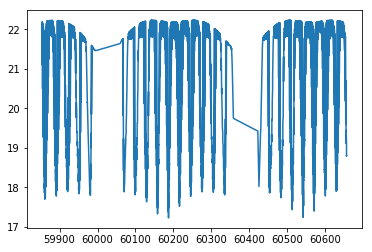

In [16]:
good = ~np.isnan(g_sb)
plt.plot(mjd[good], g_sb[good])

In [17]:
ddf_airmass[good]

array([ 1.20977504,  1.20247557,  1.19877867, ..., -1.22307345,
       -1.23785418, -1.25619914])

In [18]:
dist_to_moon = ddf_coord.separation(moon_coords)

In [19]:
seeing_model = SeeingModel()
ddf_approx_fwhmEff = seeing_model(0.7, ddf_airmass)
# I think this should pluck out the g-filter. Really should be labled
ddf_approx_fwhmEff = ddf_approx_fwhmEff['fwhmEff'][1].ravel()

/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:126: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


In [20]:
ddf_m5 = m5_flat_sed('g', g_sb, ddf_approx_fwhmEff, 30., ddf_airmass, nexp=1.)

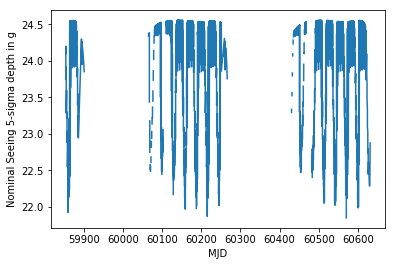

In [21]:
# demand sun down past twilight, ddf is up, and observatory is open, and not too close to the moon
good = np.where((ddf_airmass < airmass_limit) & (sun_altaz.alt < twilight_limit*u.deg) &
                (ddf_airmass > 0) & (observatory_up == True) & (dist_to_moon > dist_to_moon_limit*u.deg))
plt.plot(mjd[good], ddf_m5[good])
plt.xlabel('MJD')
plt.ylabel('Nominal Seeing 5-sigma depth in g')